In [1]:
# Import libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob

# # Consider adding the following from Ben Smith's tutorial
# import os
# import h5py
# from glob import glob
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.signal
## data_dir='ATL06/Byrd_glacier_rel001/'

import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)


# # make sure we're dealing with the most recent version of any code we're using
# %load_ext autoreload
# %autoreload 2

In [2]:
! ls ~/data/nsidc/**/*.h5

/home/jovyan/data/nsidc/161027313/processed_ATL06_20181019231110_03260102_001_01.h5
/home/jovyan/data/nsidc/161076435/processed_ATL06_20181030110205_04860106_001_01.h5
/home/jovyan/data/nsidc/161253216/processed_ATL06_20190118185056_03260202_001_01.h5


In [3]:
# Establish directories
data_dir = '/home/jovyan/data/nsidc/**/'

In [4]:
fns = []

# Get the filenames and append to a list
for f in glob.glob(data_dir + "*.h5"):
    # append full filename to list of filenames
    fns.append(f)  

# sort the list
fns.sort()
fns

['/home/jovyan/data/nsidc/161027313/processed_ATL06_20181019231110_03260102_001_01.h5',
 '/home/jovyan/data/nsidc/161076435/processed_ATL06_20181030110205_04860106_001_01.h5',
 '/home/jovyan/data/nsidc/161253216/processed_ATL06_20190118185056_03260202_001_01.h5']

In [5]:
# Specify the last HDF5 file from the list as a test case
myfile_fn = fns[-1]
myfile_fn

'/home/jovyan/data/nsidc/161253216/processed_ATL06_20190118185056_03260202_001_01.h5'

In [6]:
# Inspect metadata with Fernando Paolo's python function

def print_attrs(name, obj):
    print(name)
    for key,val in obj.attrs.items():
        print("    %s: %s" % (key, val))
     

In [7]:
# # This outputs a whole lot of metadata
# f = h5py.File(myfile_fn, 'r')  # keep it open in read mode

# # Inspect base groups quickly
# print(f.keys())

# # print attributes using previously-defined function
# f.visititems(print_attrs)   

# f.close()

In [8]:
def ATL06_to_dict(filename, dataset_dict):
    """
        Read selected datasets from an ATL06 file

        Input arguments:
            filename: ATl06 file to read
            dataset_dict: A dictinary describing the fields to be read
                    keys give the group names to be read, 
                    entries are lists of datasets within the groups
        Output argument:
            D6: dictionary containing ATL06 data.  Each dataset in 
                dataset_dict has its own entry in D6.  Each dataset 
                in D6 contains a list of numpy arrays containing the 
                data
    """
    
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                
                                bad=temp[dataset]==fill_value
                                temp[dataset]=np.float32(temp[dataset])
                                temp[dataset][bad]=np.NaN
#                                 temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                        except TypeError:
                            print(type(fill_value))
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

In [9]:
dataset_dict={'land_ice_segments':['h_li', 'delta_time','longitude','latitude'], 'land_ice_segments/ground_track':['x_atc']}

In [10]:
%matplotlib inline

# read ATL06 into a dictionary (the ATL06 file has the same name as the ATL03 file, except for the product name)
ATL06_file=myfile_fn
D6_list=ATL06_to_dict(ATL06_file, dataset_dict)

# pick out gt1r:
D6 = D6_list[0]
D6

{'h_li': array([      nan, 1598.1129, 1599.9465], dtype=float32),
 'delta_time': array([33072997.56126441, 33072997.60031595, 33072997.60595344]),
 'longitude': array([-121.90938255, -121.9098725 , -121.90992424]),
 'latitude': array([48.71004147, 48.71254447, 48.71290321]),
 'pair': array([1., 1., 1.], dtype=float32),
 'beam': array([0., 0., 0.], dtype=float32),
 'filename': '/home/jovyan/data/nsidc/161253216/processed_ATL06_20190118185056_03260202_001_01.h5'}

### Plot granules

read 18 beam/pair combinations


/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/srv/conda/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


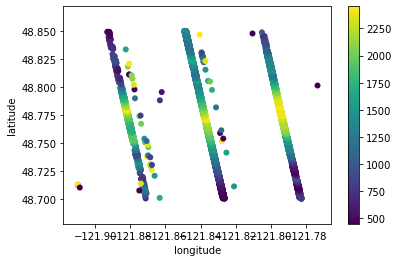

In [11]:
# %matplotlib widget

D6=[]
pairs=[1, 2, 3]
beams=['l','r']

files=glob.glob(data_dir+'/*.h5')
for file in files:
    this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)
print("read %d beam/pair combinations" % (len(D6)))

# now plot the results:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], 
                #vmin=0, vmax=2000, 
                linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

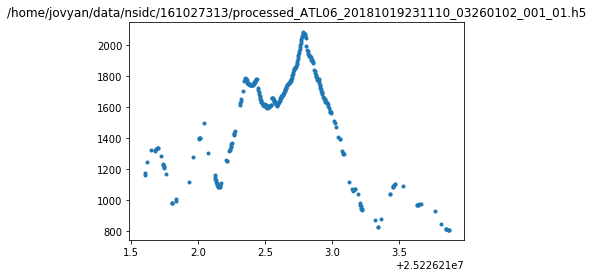

In [12]:
# %matplotlib widget
for file in [files[0]]:
    this_D6=ATL06_to_dict(file, dataset_dict)
    plt.figure()
    plt.plot(this_D6[1]['delta_time'], this_D6[1]['h_li'],'.')
    plt.title(this_D6[1]['filename'])

In [13]:
files[0]

'/home/jovyan/data/nsidc/161027313/processed_ATL06_20181019231110_03260102_001_01.h5'

In [14]:
from osgeo import gdal
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

### plot tracks over srtm data

In [15]:
D6=[]
pairs=[1, 2, 3]
beams=['l','r']

files=glob.glob(data_dir+'/*.h5')
for file in files:
    this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)
print("read %d beam/pair combinations" % (len(D6)))

read 18 beam/pair combinations


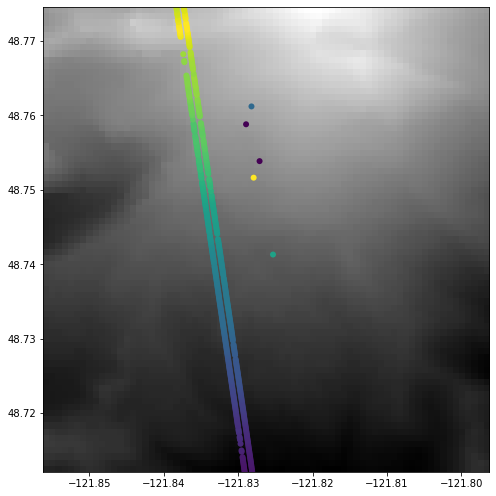

In [16]:
srtm_wa_subset_vrt = rasterio.open('/home/jovyan/data/srtm_elevation/SRTM3/cache/srtm_wa_subset.vrt')
f,ax = plt.subplots(figsize=(8,10))
for Di in D6:
    ax.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], 
                #vmin=0, vmax=2000, 
                linewidth=0)
show(srtm_wa_subset_vrt, ax=ax,cmap='gray')

In [22]:
xmin,ymin,xmax,ymax = srtm_wa_subset_vrt.bounds

In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [18]:
def point_covert(row):
    geom = Point(row['longitude'],row['latitude'])
    return geom

def ATL06_2_gdf(ATL06_fn,dataset_dict):
    """
    function to convert ATL06 hdf5 to geopandas dataframe, containing columns as passed in dataset dict
    Used Ben's ATL06_to_dict function
    """
    if ('latitude' in dataset_dict['land_ice_segments']) != True:
        dataset_dict['land_ice_segments'].append('latitude')
    if ('longitude' in dataset_dict['land_ice_segments']) != True:
        dataset_dict['land_ice_segments'].append('longitude')
    #use Ben's Scripts to convert to dict
    data_dict = ATL06_to_dict(ATL06_fn,dataset_dict)
    #this will give us 6 tracks
    i = 0
    for track in data_dict:
        #1 track
        #convert to datafrmae
        df = pd.DataFrame(track)
        df['p_b'] = str(track['pair'][0])+'_'+str(track['beam'][0])
        df['geometry'] = df.apply(point_covert,axis=1)
        if i==0:
            df_final = df.copy()
        else:
            df_final = df_final.append(df)
        i = i+1
    gdf_final = gpd.GeoDataFrame(df_final,geometry='geometry',crs={'init':'epsg:4326'})
    return gdf_final

In [19]:
df_0 = ATL06_2_gdf(files[0], dataset_dict)
df_1 = ATL06_2_gdf(files[1], dataset_dict)
df_2 = ATL06_2_gdf(files[2], dataset_dict)

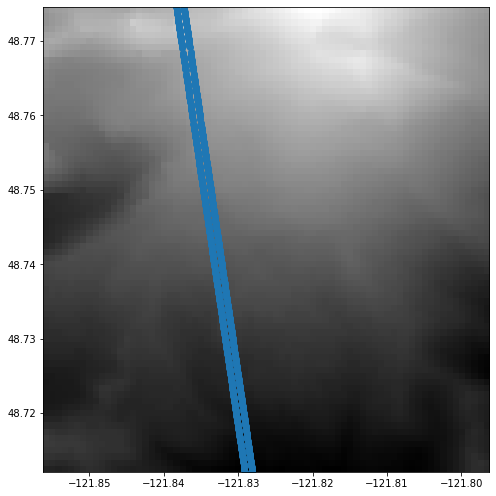

In [70]:
f,ax = plt.subplots(figsize=(8,10))
df_0.plot(ax=ax)
show(srtm_wa_subset_vrt, ax=ax, cmap='gray')

In [62]:
srtm_vrt_file = '/home/jovyan/data/srtm_elevation/SRTM3/cache/srtm_wa_subset.vrt'

In [69]:
refdem = rasterio.open(srtm_vrt_file)
points_xy = list(zip(df_0.geometry.x, df_0.geometry.y))

refdem_sample = []
for val in refdem.sample(points_xy):
    print(val[0])
    refdem_sample.append(val[0])

-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-32768.0
-

IndexError: index 0 is out of bounds for axis 1 with size 0

read 174 beam/pair combinations


/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/srv/conda/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


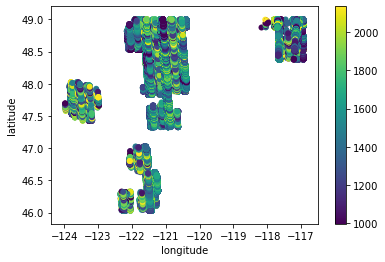

In [11]:
# %matplotlib widget

D6=[]
pairs=[1, 2, 3]
beams=['l','r']

files=glob.glob(data_dir+'/*.h5')
for file in files:
    this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)
print("read %d beam/pair combinations" % (len(D6)))

# now plot the results:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], 
                #vmin=0, vmax=2000, 
                linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

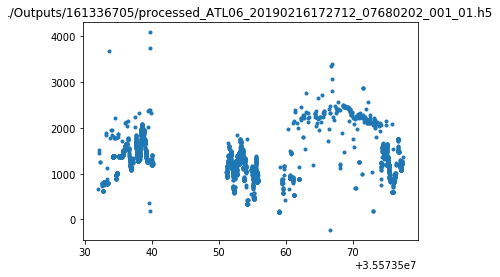

In [12]:
# %matplotlib widget
for file in [files[0]]:
    this_D6=ATL06_to_dict(file, dataset_dict)
    plt.figure()
    plt.plot(this_D6[1]['delta_time'], this_D6[1]['h_li'],'.')
    plt.title(this_D6[1]['filename'])

In [52]:
# ! ls -al ./outputs/baker/**/

In [78]:
files[0]

'./outputs/baker/161027313/processed_ATL06_20181019231110_03260102_001_01.h5'

# Scrap

In [80]:
import xarray as xr


ds = xr.open_dataset(files[0])
# ds

In [77]:
ds = xr.open_dataset(files[0],group='/gt3r/land_ice_segments')
ds

<xarray.Dataset>
Dimensions:                (delta_time: 689)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-10-19T23:16:51.413560248 ... 2018-10-19T23:16:53.750269712
    latitude               (delta_time) float64 ...
    longitude              (delta_time) float64 ...
Data variables:
    atl06_quality_summary  (delta_time) int8 ...
    h_li                   (delta_time) float32 ...
    h_li_sigma             (delta_time) float32 ...
    segment_id             (delta_time) float64 ...
    sigma_geo_h            (delta_time) float32 ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...

In [76]:
ds = xr.open_mfdataset(files,group='/gt3r/land_ice_segments')

In [74]:
ds

<xarray.Dataset>
Dimensions:                (delta_time: 726)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 2018-10-19T23:16:51.413560248 ... 2019-01-18T18:56:39.930891940
    latitude               (delta_time) float64 dask.array<shape=(726,), chunksize=(689,)>
    longitude              (delta_time) float64 dask.array<shape=(726,), chunksize=(689,)>
Data variables:
    atl06_quality_summary  (delta_time) int8 dask.array<shape=(726,), chunksize=(689,)>
    h_li                   (delta_time) float32 dask.array<shape=(726,), chunksize=(689,)>
    h_li_sigma             (delta_time) float32 dask.array<shape=(726,), chunksize=(689,)>
    segment_id             (delta_time) float64 dask.array<shape=(726,), chunksize=(689,)>
    sigma_geo_h            (delta_time) float32 dask.array<shape=(726,), chunksize=(689,)>
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data valu

In [ ]:
# gdf = gpd.GeoDataFrame().reindex_like(df)
for file in files:
    df = ATL06_2_gdf(file, dataset_dict)
    gdf.append(df)